<a href="https://colab.research.google.com/github/dragoa/AI/blob/main/SecML/01_Evasion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evasion attacks against Machine Learning models

As seen in class, machine learning models can be fooled by *adversarial examples*, samples artificially crafted to redirect the output of the victim towards a desired result.

These attacks can be either:

* **targeted**, in which the attacker wants to produce a specific misclassification (e.g. a dog must be recognized as a cat); or
* **untargeted**, in which the attacker is satisfied with producing a generic misclassification (e.g. a dog will be recognized as anything else but a dog).

Both targeted and untargeted attacks are formulated as optimization problems.

### Targeted attacks

Targeted attacks that can be written as:

$$
  \min_\boldsymbol{\delta} L(\boldsymbol{x} + \boldsymbol{\delta}, y_t; \boldsymbol{\theta})
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where $L$ is the objective function of our attack (it defines the goal of the attacker, *i.e.*, where to find adversarial examples), $\boldsymbol{x}$ is the sample to perturb, $y_t$ is the target label, $\boldsymbol{\theta}$ are the parameters of the model, $\epsilon$ is the maximum allowed perturbation, and $\boldsymbol{l}_b,\boldsymbol{l}_u$ are the input-space bounds (for instance, images must be clipped in 0-1 or 0-255 to be valid samples).


### Untargeted attacks

Untargeted attacks can be formulated as:

$$
  \max_\boldsymbol{\delta} L(\boldsymbol{x} + \boldsymbol{\delta}, y; \boldsymbol{\theta})
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where we change the minimization to a *maximization*, since we want to maximize the error of the classifier w.r.t. the real label $y$.

We start by implementing *untargeted* evasion attacks, and we need to define two main components: the *optimization algorithm* and the *loss function* of the attack. While the second one can be *any* distance function, we will now describe one particular optimizer.

In this exercise, we will leverage the *projected gradient descent* [1,2] optimizer, by implementing it step by step in SecML.

First, we create a simple 2D dataset that we will use in this tutorial, and we fit a simple neural network on top of it.

[1] Biggio et al. "Evasion attacks against machine learning at test time", ECML PKDD 2013, https://arxiv.org/abs/1708.06131
[2] Madry et al. "Towards deep learning models resistant to adversarial attacks", ICLR 2018, https://arxiv.org/pdf/1706.06083.pdf

In [1]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml
    %pip install foolbox

  Cloning https://github.com/pralab/secml to /tmp/pip-req-build-pcshq0jw
  Running command git clone --filter=blob:none --quiet https://github.com/pralab/secml /tmp/pip-req-build-pcshq0jw
  Resolved https://github.com/pralab/secml to commit e7463f2114ddf507a32a74c80e401574d7d9e086
  Preparing metadata (setup.py) ... done
  Created wheel for secml: filename=secml-0.15.6-py3-none-any.whl size=463966 sha256=0480ddfb923163ab22e0986096dcf614fa5e235e154c12b07066d613fcbe7990
  Stored in directory: /tmp/pip-ephem-wheel-cache-_nv45cxt/wheels/22/d7/97/6c54183f8e63358a946e938cc5ca912832afe4a0b9d9b3d736
Successfully built secml
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [2]:
random_state = 999

n_features = 2 # number of features
n_samples = 1250 # number of samples
centers = [[-2, 0], [2, -2], [2, 2]] # centers of the clusters
cluster_std = 0.8 # standard deviation of the clusters
n_classes = len(centers) # number of classes

from secml.data.loader import CDLRandomBlobs

# generate the dataset
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000 # number of training set samples
n_ts = 250 # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

2023-10-20 10:02:41,779 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2023-10-20 10:02:41,779 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2023-10-20 10:02:41,800 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2023-10-20 10:02:41,800 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2023-10-20 10:02:41,824 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2023-10-20 10:02:41,824 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2023-10-20 10:02:41,835 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2023-10-20 10:02:41,835 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2023-10-20 10:02:41,840 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2023-10-20 10:02:41,840 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2023-10-20 10:02:41,849 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2023-10-20 10:02:41,849 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2023-10-20 10:02:41,857 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2023-10-20 10:02:41,857 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


In [3]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.peval.metrics import CMetricAccuracy


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden) # Create a fully connected layer with n_hidden neurons
        self.fc2 = nn.Linear(n_hidden, n_classes) # Create another fully connected layer with n_classes neurons

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Apply ReLU activation to the output of the first layer
        x = self.fc2(x) # Pass the output through the second layer
        return x


# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

# Define a loss function (Cross-Entropy) and an optimizer (Stochastic Gradient Descent - SGD)
criterion = nn.CrossEntropyLoss() # Cross-Entropy loss is commonly used for multiclass classification
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

# fit the classifier with training data
clf.fit(tr.X, tr.Y)

# compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Accuracy on test set: 99.60%


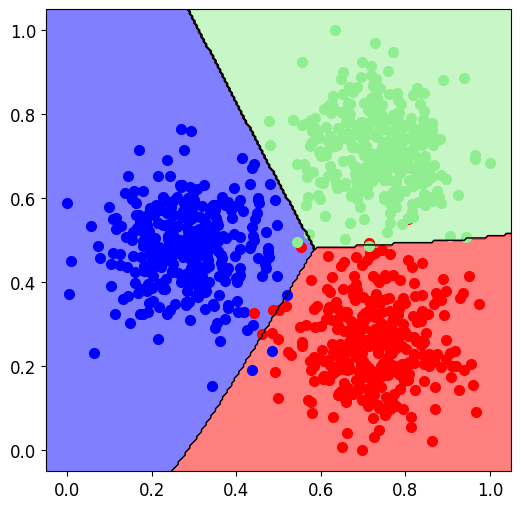

In [12]:
%matplotlib inline

# plot the samples and the decision function of the classifier
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=200)
fig.show()

## Projected Gradient Descent (PGD)

We can now create the attack that will compute adversarial examples against the trained classifier.
We leverage Projected Gradient Descent, that works as follow:

![PGD-algorithm](https://github.com/zangobot/teaching_material/blob/HEAD/assets/pgd_attack.png?raw=1)

First, the attack is initialized by chosing a starting point for the descent, by also specifying the maximum perturbation budget $\epsilon$, the step-size $\alpha$, and the number of iterations.
At each iteration, the strategy computes the gradient of the model, and it updates the adversarial example by following the computed direction.
Lastly, if the applied perturbation is more than the intended perturbation budget $\varepsilon$, the algorithm projects this sample back inside a valid $\ell_p$-ball centered on the starting point, with radius $\varepsilon$.

We use an $\ell_2$ perturbation here, for limiting the maximum Euclidean distance of the perturbed point from the original point to $\varepsilon$.
The PGD attack uses the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) for creating adversarial examples.

Recalling from the previous definitions, the objectives can be customized for targeted and untargeted attacks.

* Targeted attack: minimize CE Loss on the target class (makes the model classify the sample as $y_t$)
* Untargeted attack: maximize the CE Loss on the original class (makes the model not classify the sample as $y$)

In [5]:
# We now implement PGD for an UNTARGETED attack step by step
# untarget attack -> I want to maximize the error

from secml.ml.classifiers.loss import CLossCrossEntropy
from secml.array import CArray


def pgd_l2_untargeted(x, y, clf, eps, alpha, steps):
    # defining the loss function
    loss_func = CLossCrossEntropy()
    x_adv = x.deepcopy()  # makes a copy of the original sample

    # we use a CArray to store intermediate results
    path = CArray.zeros((steps + 1, x.shape[1]))
    path[0, :] = x_adv  # store initial point

    # we iterate multiple times to repeat the gradient descent step
    for i in range(steps):
        # we calculate the output of the model (not the loss)
        scores = clf.decision_function(x_adv)

        # we compute the gradient of the loss w.r.t. the clf logits
        loss_gradient = loss_func.dloss(y_true=y, score=scores)

        # we compute gradient of the clf logits w.r.t. the input
        clf_gradient = clf.grad_f_x(x_adv, y)

        # With the chain rule, we compute the gradient of the CE loss w.r.t. the input of the network
        gradient = clf_gradient * loss_gradient

        # normalize the gradient (takes only the direction and discards the magnitude) (remeber to avoid division by 0)
        if gradient.norm() != 0:
           gradient /= gradient.norm()

        # apply the gradient descent step, by summing the normalized gradient (multiplied by the stepsize) to the sample
        x_adv = x_adv + alpha * gradient

        # re-project inside epsilon-ball
        delta = x_adv - x
        if delta.norm() > eps:
            delta = delta / delta.norm() * eps
            x_adv = x + delta

        # force input bounds
        x_adv = x_adv.clip(0, 1)

        # store point in the path
        path[i + 1, :] = x_adv

    return x_adv, clf.predict(x_adv), path

In [6]:
index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y
steps = 200
eps = 0.3
alpha = 0.1

print(f"Starting point has label: {y0.item()}")
x_adv, y_adv, attack_path = pgd_l2_untargeted(x0, y0, clf, eps, alpha, steps)
print(f"Adversarial point has label: {y_adv.item()}")

Starting point has label: 0
Adversarial point has label: 2


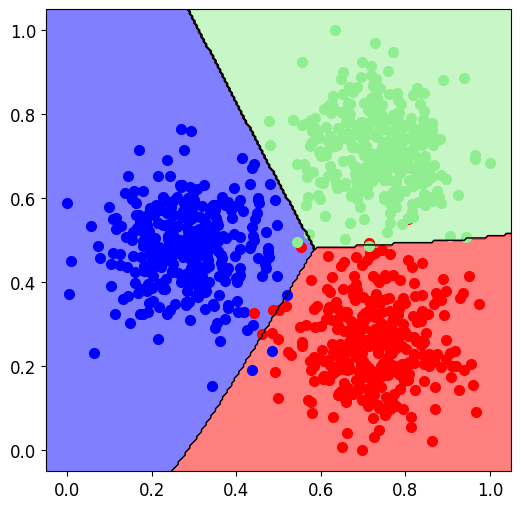

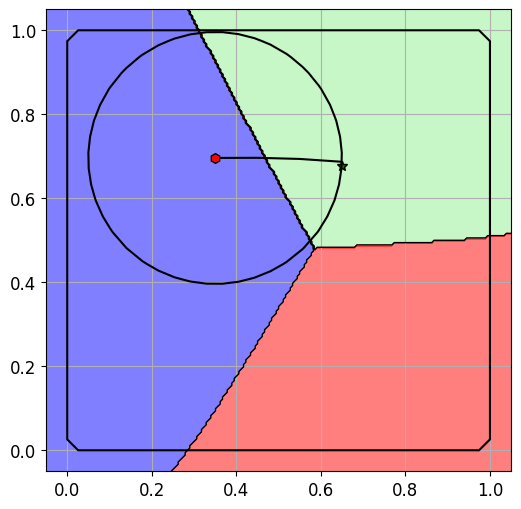

In [7]:
%matplotlib inline

from secml.figure import CFigure
from secml.optim.constraints import CConstraintL2, CConstraintBox

fig = CFigure()
fig.sp.plot_decision_regions(clf, plot_background=True, n_grid_points=200)

# maximum perturbation allowed
constraint = CConstraintL2(center=x0, radius=eps)
fig.sp.plot_path(attack_path)
fig.sp.plot_constraint(constraint)

# feature bounds
input_bounds = CConstraintBox(lb=0.0, ub=1.0)
fig.sp.plot_constraint(input_bounds)
fig.show()

Evasion achieved!
As you could see, the process is not bug-free, and it is complex to handle.
Hence, SecML provides a lot of attack wrappers to accomplish the same task effortlessly.

In [8]:
from secml.adv.attacks.evasion import CFoolboxPGDL2

index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y
steps = 200
eps = 0.3
alpha = 0.1

y_target = None
lb = tr.X.min()  # lower bound of the input space
ub = tr.X.max()  # upper bound of the input space

pgd_attack = CFoolboxPGDL2(clf, y_target,
                           lb=lb, ub=ub,
                           epsilons=eps,
                           abs_stepsize=alpha,
                           steps=steps,
                           random_start=False)

y_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-L2): ", y_pred.item())

Original x0 label:  0
Adversarial example label (PGD-L2):  2


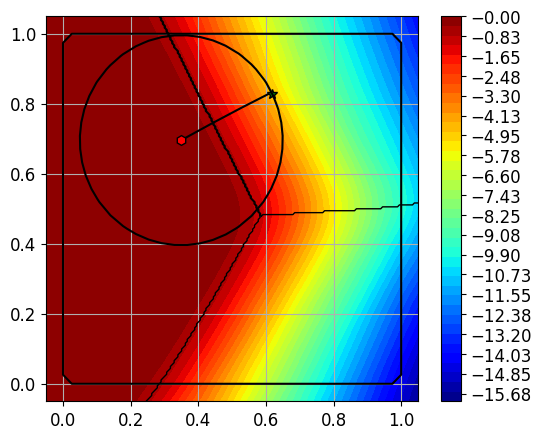

In [9]:
%matplotlib inline
# let's plot again
fig = CFigure(height=5, width=6)
fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

# let's plot the objective function of the attack
fig.sp.plot_fun(pgd_attack.objective_function, n_grid_points=200, plot_levels=False)

constraint = CConstraintL2(center=x0, radius=eps)
fig.sp.plot_path(pgd_attack.x_seq)
fig.sp.plot_constraint(constraint)
input_bounds = CConstraintBox(lb=0.0, ub=1.0)
fig.sp.plot_constraint(input_bounds)
fig.show()

## Exercise

Use the tutorial above and [the first tutorial](01_intro_secml.ipynb) to create evasion attacks against a Deep Neural Network trained on the MNIST classifier.

1. Load the MNIST dataset and create a Neural Network with PyTorch.
2. Train the model on the MNIST dataset with SecML.
3. Use the PGD-LInf attack with $\varepsilon=0.3$, $\alpha=0.01$ and 200 steps to create an adversarial digit.
4. (optional) Use the utility function used before to show the original and perturbed digit along with their predictions.
5. Check out the other attacks available in [SecML](https://secml.readthedocs.io/)!


In [10]:
# TODO write your code here